In [9]:
import matplotlib
print(matplotlib.get_cachedir())

/Users/tk/.matplotlib


In [ ]:
import pandas as pd
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm # เพิ่ม import นี้
import os


try:
    font_path = '/System/Library/Fonts/Supplemental/Tahoma.ttf' # สำหรับ macOS
    font_prop = fm.FontProperties(fname=font_path)
    if not os.path.exists(font_path):
        font_path = 'C:/Windows/Fonts/tahoma.ttf' # สำหรับ Windows
        font_prop = fm.FontProperties(fname=font_path)
except Exception:
    print("ไม่พบฟอนต์ Tahoma ในที่อยู่มาตรฐาน, กราฟอาจยังเป็นสี่เหลี่ยม")
    font_prop = fm.FontProperties(family='sans-serif') # ใช้ฟอนต์สำรอง
# --------------------------------------------------

# --- ตั้งค่า Path ---
PROCESSED_DIR = '../data/processed'
RAINFALL_PATH = os.path.join(PROCESSED_DIR, 'daily_rainfall_2024_processed.csv')
OUTPUT_PATH = os.path.join(PROCESSED_DIR, 'daily_rainfall_anomaly_results.csv')

def run_anomaly_detection(data_path=RAINFALL_PATH):
    """
    ฟังก์ชันสำหรับตรวจจับความผิดปกติของข้อมูลปริมาณน้ำฝน
    """
    print(f"--- 4. กำลังสร้างโมเดล Anomaly Detection จากไฟล์: {data_path} ---")

    try:
        df = pd.read_csv(data_path, parse_dates=['date'], index_col='date')
    except FileNotFoundError:
        print(f"❌ ไม่พบไฟล์ '{data_path}'! กรุณารันสคริปต์เตรียมข้อมูลก่อน")
        return

    # (ส่วนประมวลผลข้อมูลเหมือนเดิม)
    df['rainfall_ma_7'] = df['avg_rainfall_mm'].rolling(window=7, min_periods=1).mean()
    df['rainfall_sum_3'] = df['avg_rainfall_mm'].rolling(window=3, min_periods=1).sum()
    print("สร้าง Features เพิ่มเติม (ฝนสะสม, ค่าเฉลี่ยเคลื่อนที่) เรียบร้อยแล้ว")
    features_to_use = ['avg_rainfall_mm', 'rainfall_ma_7', 'rainfall_sum_3']
    X = df[features_to_use]
    model = IsolationForest(contamination=0.05, random_state=42)
    model.fit(X)
    df['anomaly_score'] = model.decision_function(X)
    df['is_anomaly'] = model.predict(X)
    print("ตรวจจับความผิดปกติเรียบร้อยแล้ว")
    anomalies = df[df['is_anomaly'] == -1]
    print(f"\nตรวจพบวันที่อาจมีความผิดปกติทั้งหมด: {len(anomalies)} วัน")
    print("\n**ตัวอย่างวันที่ตรวจพบความผิดปกติ (เรียงตามคะแนน):**")
    print(anomalies.sort_values('anomaly_score').head())

    # --- ✨ ส่วนที่ 2: แก้ไขการวาดกราฟให้ใช้ font_prop ---
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(15, 7))
    plt.plot(df.index, df['avg_rainfall_mm'], color='royalblue', label='ปริมาณฝนเฉลี่ยรายวัน')
    plt.scatter(anomalies.index, anomalies['avg_rainfall_mm'], color='red', s=50, label='วันที่ตรวจพบความผิดปกติ (Anomaly)')
    
    # เพิ่ม fontproperties=font_prop ในทุกส่วนที่เป็นภาษาไทย
    plt.title('ผลการตรวจจับความผิดปกติของปริมาณน้ำฝนปี 2024', fontproperties=font_prop, fontsize=18, pad=20)
    plt.xlabel('วันที่', fontproperties=font_prop, fontsize=12)
    plt.ylabel('ปริมาณฝนเฉลี่ย (mm)', fontproperties=font_prop, fontsize=12)
    
    # สำหรับ legend ต้องทำแบบนี้
    plt.legend(prop=font_prop)

    plt.tight_layout()
    plt.show()
    # ---------------------------------------------------------

    # --- บันทึกผลลัพธ์ ---
    df.to_csv(OUTPUT_PATH)
    print(f"✅ บันทึกผลลัพธ์การตรวจจับความผิดปกติเรียบร้อยแล้วที่ '{OUTPUT_PATH}'")

# --- รันโค้ด ---
if __name__ == '__main__':
    run_anomaly_detection()

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- 🎨 ตั้งค่าฟอนต์ภาษาไทย ---
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Tahoma'] # ใช้ Tahoma เป็นฟอนต์เริ่มต้นที่มักจะมีในเครื่อง
# ------------------------------------

# --- ตั้งค่า Path ---
PROCESSED_DIR = '../data/processed'
RISK_PROFILE_PATH = os.path.join(PROCESSED_DIR, 'district_risk_profile_processed.csv')
OUTPUT_PATH = os.path.join(PROCESSED_DIR, 'district_cluster_results.csv')

def run_clustering_analysis(data_path=RISK_PROFILE_PATH, n_clusters=4):
    """
    ฟังก์ชันสำหรับทำ Clustering เพื่อจัดกลุ่มเขตตามความเสี่ยง
    """
    print(f"--- 2. กำลังสร้างโมเดล Clustering จากไฟล์: {data_path} ---")
    
    try:
        df = pd.read_csv(data_path)
        df.dropna(subset=['เขต'], inplace=True) # <-- ✨ เพิ่มบรรทัดนี้
    except FileNotFoundError:
        print(f"❌ ไม่พบไฟล์ '{data_path}'! กรุณารันสคริปต์เตรียมข้อมูล (01) ก่อน")
        return

    features_to_use = [
        'คะแนนรวม',
        'จำนวนจุดเสี่ยง',
        'จำนวนจุดเฝ้าระวังน้ำท่วม',
        'AREA'
    ]
    
    # --- ✨ ส่วนที่แก้ไข: วนลูปเพื่อตรวจสอบและเติมค่า NaN ในทุกคอลัมน์ ---
    print("กำลังตรวจสอบและเติมค่าว่าง (NaN) ใน Features ที่จะใช้...")
    for col in features_to_use:
        if df[col].isnull().any():
            mean_val = df[col].mean()
            # แก้ไขตามคำแนะนำ FutureWarning เพื่อให้โค้ดทันสมัยขึ้น
            df[col] = df[col].fillna(mean_val)
            print(f"  - เติมค่า NaN ในคอลัมน์ '{col}' ด้วยค่าเฉลี่ย: {mean_val:.2f}")

    X = df[features_to_use]

    # --- 2. การปรับสเกลข้อมูล (Feature Scaling) ---
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    print("ปรับสเกลข้อมูล (Standardization) เรียบร้อยแล้ว")

    # --- 3. สร้างและฝึกโมเดล K-Means ---
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    kmeans.fit(X_scaled) # ครั้งนี้จะไม่มี Error NaN แล้ว

    # --- 4. เพิ่มผลลัพธ์การจัดกลุ่มกลับเข้าไปในตารางเดิม ---
    df['Cluster'] = kmeans.labels_
    print(f"จัดกลุ่มเขตทั้งหมดออกเป็น {n_clusters} กลุ่มเรียบร้อยแล้ว")

    # --- 5. วิเคราะห์และแสดงผลลัพธ์ ---
    print("\n**สรุปจำนวนเขตในแต่ละกลุ่ม:**")
    print(df['Cluster'].value_counts().sort_index())

    plt.figure(figsize=(10, 6))
    sns.countplot(x='Cluster', data=df, palette='viridis', order=sorted(df['Cluster'].unique()))
    plt.title('จำนวนเขตในแต่ละกลุ่ม (Cluster)', fontsize=16)
    plt.xlabel('กลุ่ม (Cluster)', fontsize=12)
    plt.ylabel('จำนวนเขต', fontsize=12)
    plt.show()

    cluster_summary = df.groupby('Cluster')[features_to_use].mean().round(2)
    print("\n**ค่าเฉลี่ยของแต่ละ Feature ในแต่ละกลุ่ม (เพื่อตีความหมาย):**")
    print(cluster_summary)
    
    print("\n**รายชื่อเขตในแต่ละกลุ่ม:**")
    for i in sorted(df['Cluster'].unique()):
        print(f"\n--- กลุ่มที่ {i} ---")
        print(df[df['Cluster'] == i]['เขต'].tolist())

    # --- 6. บันทึกผลลัพธ์ ---
    df.to_csv(OUTPUT_PATH, index=False, encoding='utf-8-sig')
    print(f"\n✅ บันทึกผลลัพธ์การจัดกลุ่มเรียบร้อยแล้วที่ '{OUTPUT_PATH}'")


# --- รันโค้ด ---
if __name__ == '__main__':
    # เราจะลองแบ่งเขตออกเป็น 4 กลุ่ม (คุณสามารถปรับเปลี่ยนตัวเลขนี้ได้)
    run_clustering_analysis(n_clusters=4)

In [ ]:
import pandas as pd
import os

# --- 1. Setup and Load Data ---
PROCESSED_DIR = '../data/processed'
CLUSTER_RESULTS_PATH = os.path.join(PROCESSED_DIR, 'district_cluster_results.csv')
ANOMALY_RESULTS_PATH = os.path.join(PROCESSED_DIR, 'daily_rainfall_anomaly_results.csv')

try:
    df_clusters = pd.read_csv(CLUSTER_RESULTS_PATH)
    df_anomalies = pd.read_csv(ANOMALY_RESULTS_PATH, parse_dates=['date'])
except FileNotFoundError:
    print("❌ Cannot find processed files! Please run notebooks 02 and 03 first.")
    # Exit if files are not found
    exit()

print("✅ Successfully loaded cluster and anomaly results.")


# --- 2. Define Risk Profiles for Each Cluster ---
# Based on our previous analysis of the clusters.
# We'll assign a human-readable risk level to each cluster number.
# IMPORTANT: Adjust the cluster numbers if your results are different.
cluster_risk_mapping = {
    3: "🌋 เขตเดี่ยวพิเศษ (Special High-Risk)", # หนองจอก
    2: "🧡 เขตเมืองชั้นใน (High-Risk Core)",
    0: "💛 เขตเฝ้าระวังพิเศษ (Watchlist)",
    1: "💚 เขตขยายตัว (Mid-Risk Suburbs)"
}
df_clusters['Risk_Level'] = df_clusters['Cluster'].map(cluster_risk_mapping)

print("\n--- Risk Profiles Defined ---")
print(df_clusters[['Cluster', 'Risk_Level']].drop_duplicates().sort_values('Cluster'))


# --- 3. Create the Alerting Function ---
def generate_daily_alert(target_date):
    """
    Checks the rainfall anomaly for a given date and generates a targeted alert.
    """
    
    target_date = pd.to_datetime(target_date)
    
    # Find the anomaly data for the target date
    daily_data = df_anomalies[df_anomalies['date'] == target_date]
    
    if daily_data.empty:
        return f"No rainfall data found for {target_date.date()}."
        
    is_anomaly = daily_data['is_anomaly'].iloc[0]
    rainfall = daily_data['avg_rainfall_mm'].iloc[0]
    
    print("\n" + "="*50)
    print(f"📅 Generating Alert for: {target_date.date()}")
    print(f"🌧️ Average Rainfall: {rainfall:.2f} mm")
    print("="*50)

    # --- This is the core logic of the Alert Matrix ---
    if is_anomaly == -1: # Anomaly detected!
        print("🚨 THREAT LEVEL: HIGH - Anomaly Detected!")
        print("Recommended Actions: Activate high-level monitoring and preparedness protocols.\n")
        
        # Alert the highest risk groups first
        print("--- 🌋 SPECIAL HIGH-RISK ALERT ---")
        special_risk_districts = df_clusters[df_clusters['Risk_Level'] == cluster_risk_mapping[3]]['เขต'].tolist()
        print(f"Districts to monitor with highest priority: {special_risk_districts}")
        
        print("\n--- 🧡 HIGH-RISK CORE ALERT ---")
        high_risk_districts = df_clusters[df_clusters['Risk_Level'] == cluster_risk_mapping[2]]['เขต'].tolist()
        print(f"Districts to prepare for potential impacts: {high_risk_districts}")
        
    else: # Normal day
        print("✅ THREAT LEVEL: LOW - Normal Rainfall Pattern")
        print("No immediate action required. Continue standard monitoring.")

# --- 4. Simulate and Run ---
# Let's test the function on a few dates.

# Test Case 1: A day that the model identified as an anomaly
# (Find a date with is_anomaly == -1 from your 'daily_rainfall_anomaly_results.csv')
anomalous_date = df_anomalies[df_anomalies['is_anomaly'] == -1]['date'].iloc[0]
generate_daily_alert(anomalous_date)

# Test Case 2: A normal day (e.g., the first day of the year)
generate_daily_alert('2024-01-01')

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

# --- 🎨 1. ตั้งค่าพื้นฐานและฟอนต์ภาษาไทย ---
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Tahoma'] 

# --- 📂 2. ตั้งค่า Path และโหลดข้อมูล ---
PROCESSED_DIR = '../data/processed'
CLUSTER_FILE = os.path.join(PROCESSED_DIR, 'district_cluster_results.csv')
ANOMALY_FILE = os.path.join(PROCESSED_DIR, 'daily_rainfall_anomaly_results.csv')

try:
    df_clusters = pd.read_csv(CLUSTER_FILE)
    df_anomalies = pd.read_csv(ANOMALY_FILE, parse_dates=['date'])
    print("✅ โหลดไฟล์ข้อมูลที่ประมวลผลแล้วสำเร็จ!")
except FileNotFoundError:
    print("❌ ไม่พบไฟล์ข้อมูล! กรุณารัน Notebook 01, 02, และ 03 ก่อน")
    # exit() # หากรันเป็น script .py ให้ uncomment บรรทัดนี้

# ==============================================================================
# 📊 ส่วนที่ 1: กราฟวิเคราะห์โปรไฟล์ของกลุ่มเขต (จาก district_cluster_results.csv)
# ==============================================================================
print("\n--- 🔬 กำลังสร้างกราฟวิเคราะห์โปรไฟล์ของกลุ่มเขต ---")

# --- กราฟที่ 1: กราฟฟอง (Bubble Chart) เพื่อดูการเกาะกลุ่ม ---
plt.figure(figsize=(14, 8))
sns.scatterplot(
    data=df_clusters,
    x='AREA',
    y='คะแนนรวม',
    hue='Cluster',       # สีแทนกลุ่ม
    size='จำนวนจุดเสี่ยง', # ขนาดฟองแทนจำนวนจุดเสี่ยง
    sizes=(50, 1000),    # กำหนดขนาดฟอง min, max
    palette='viridis',
    alpha=0.7
)
plt.title('การกระจายตัวของกลุ่มเขตตามขนาดพื้นที่, คะแนนรวม, และจำนวนจุดเสี่ยง', fontsize=16)
plt.xlabel('ขนาดพื้นที่ (AREA)', fontsize=12)
plt.ylabel('คะแนนความเสี่ยงรวม', fontsize=12)
plt.legend(title='กลุ่ม (Cluster)')
plt.ticklabel_format(style='plain', axis='x') # ปิด scientific notation ที่แกน X
plt.tight_layout()
plt.show()

# --- กราฟที่ 2: กราฟกล่อง (Box Plot) เพื่อเปรียบเทียบการกระจายตัว ---
features_to_plot = ['คะแนนรวม', 'จำนวนจุดเสี่ยง', 'จำนวนจุดเฝ้าระวังน้ำท่วม', 'AREA']
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('เปรียบเทียบการกระจายตัวของแต่ละ Feature ในแต่ละกลุ่ม', fontsize=20)
axes = axes.flatten() # ทำให้ access subplot ง่ายขึ้น

for i, feature in enumerate(features_to_plot):
    sns.boxplot(ax=axes[i], data=df_clusters, x='Cluster', y=feature, palette='viridis')
    axes[i].set_title(f'การกระจายตัวของ "{feature}"', fontsize=14)
    axes[i].set_xlabel('กลุ่ม (Cluster)', fontsize=10)
    axes[i].set_ylabel('')

plt.tight_layout(rect=[0, 0, 1, 0.96]) # ปรับ layout ให้ไม่ทับ suptitle
plt.show()

# --- กราฟที่ 3: กราฟเรดาร์ (Radar Chart) เพื่อดูโปรไฟล์ที่เป็นเอกลักษณ์ ---
# เตรียมข้อมูลสำหรับ Radar Chart
labels = np.array(features_to_plot)
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1] # ปิดวงกลม

# หาค่าเฉลี่ยของแต่ละกลุ่ม
cluster_summary = df_clusters.groupby('Cluster')[features_to_plot].mean()

# ทำ Scaling ข้อมูลให้อยู่ในช่วง 0-1 เพื่อให้พล็อตในแกนเดียวกันได้
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
summary_scaled = scaler.fit_transform(cluster_summary)

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# วาดเส้นสำหรับแต่ละกลุ่ม
for i, row in enumerate(summary_scaled):
    values = row.tolist()
    values += values[:1] # ปิดวงกลม
    ax.plot(angles, values, label=f'กลุ่ม {i}')
    ax.fill(angles, values, alpha=0.1)

ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids(np.degrees(angles[:-1]), labels)

plt.title('โปรไฟล์ความเสี่ยงที่เป็นเอกลักษณ์ของแต่ละกลุ่ม', size=16, y=1.1)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.show()


# ==============================================================================
# 🌧️ ส่วนที่ 2: กราฟวิเคราะห์รูปแบบของฝน (จาก daily_rainfall_anomaly_results.csv)
# ==============================================================================
print("\n--- 🌧️ กำลังสร้างกราฟวิเคราะห์รูปแบบของฝน ---")

# --- กราฟที่ 4: ฮิสโทแกรม (Histogram) เพื่อดูการกระจายตัวของปริมาณฝน ---
plt.figure(figsize=(12, 6))
sns.histplot(df_anomalies['avg_rainfall_mm'], bins=50, kde=True)
plt.title('การกระจายตัวของปริมาณน้ำฝนเฉลี่ยรายวันตลอดทั้งปี', fontsize=16)
plt.xlabel('ปริมาณฝนเฉลี่ย (mm)', fontsize=12)
plt.ylabel('ความถี่ (จำนวนวัน)', fontsize=12)
plt.show()


# --- กราฟที่ 5: กราฟกระจายของคะแนนความผิดปกติ (Anomaly Score Scatter Plot) ---
plt.figure(figsize=(12, 7))
sns.scatterplot(
    data=df_anomalies,
    x='avg_rainfall_mm',
    y='anomaly_score',
    hue='is_anomaly', # สีแทนการตัดสินใจของโมเดล (-1 คือผิดปกติ)
    palette={1: 'royalblue', -1: 'red'}
)
plt.title('ความสัมพันธ์ระหว่างปริมาณฝนและคะแนนความผิดปกติ', fontsize=16)
plt.xlabel('ปริมาณฝนเฉลี่ย (mm)', fontsize=12)
plt.ylabel('คะแนนความผิดปกติ (Anomaly Score)', fontsize=12)
plt.legend(title='สถานะ', labels=['ผิดปกติ', 'ปกติ'])
plt.show()

print("\n🎉 สร้างกราฟทั้งหมดเสร็จสิ้น!")

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. โหลดข้อมูล ---
print("--- 1. Loading Final Engineered DataFrame ---")
path_base = "../data/PROCESSED/"
engineered_df_path = path_base + "master_features_engineered.csv"

try:
    df_final = pd.read_csv(engineered_df_path)
    print(f"Successfully loaded: {engineered_df_path}")
except Exception as e:
    print(f"Error loading file: {e}")

# --- 2. Feature Selection ---
# นี่คือการ "เลือก" Feature ที่เราจะใช้ในการจัดกลุ่ม
# เราตัดตัวซ้ำซ้อน (num_male, pump_number) และตัวระบุตัวตน (dname) ทิ้ง
# เราเลือกใช้ Feature ที่เราสร้างขึ้นมา (Density, Ratio) และ Feature ฝนชุดใหม่

# คอลัมน์ One-Hot
one_hot_cols = [col for col in df_final.columns if 'group_' in col]
# ตรวจสอบให้แน่ใจว่าไม่มีคอลัมน์ซ้ำ (จาก snippet ที่ผมเห็น)
one_hot_cols = sorted(list(set(one_hot_cols)))

# คอลัมน์ตัวเลขหลัก
numeric_features = [
    'AREA',
    'population',
    # 'num_school', 'num_hos', 'num_comm', 'num_temple', 'num_health', # (เลือกได้ว่าจะใส่หรือไม่)
    'canal_count',
    'flood_point_count',
    'floodgate_count',
    'คะแนนรวม',             # risk_score
    'จำนวนจุดเสี่ยง',        # risk_points
    'จำนวนจุดเฝ้าระวังน้ำท่วม', # watch_points
    
    # New Rain Features
    'rain_max_24h',
    'rain_sum_24h',
    'rain_days_heavy',
    
    # Engineered Features
    'population_density',
    'canal_density',
    'flood_point_density',
    'floodgate_density',
    'pump_per_capita',
    'pump_readiness_ratio' # ใช้ตัวนี้แทน pump_ready
]

# รวม Feature ทั้งหมดที่จะใช้
features_for_clustering = numeric_features + one_hot_cols

# สร้าง DataFrame ชุดสุดท้ายสำหรับโมเดล
X = df_final[features_for_clustering].copy()
print(f"\n--- 2. Feature Selection Complete ---")
print(f"Using {len(features_for_clustering)} features for clustering.")


# --- 3. Preprocessing (Log Transform & Scaling) ---
print("\n--- 3. Preprocessing ---")

# 3a. Log Transformation
# เลือกคอลัมน์ที่ "เบ้ขวา" (จาก Histograms)
# (เราไม่ทำ Log กับ Ratio หรือ One-Hot)
skewed_features = [
    'AREA', 'population', 'canal_count', 'flood_point_count', 
    'floodgate_count', 'rain_max_24h', 'rain_sum_24h', 
    'population_density', 'canal_density', 'flood_point_density',
    'floodgate_density', 'pump_per_capita'
]

# ใช้ np.log1p (log(x+1)) เพื่อจัดการกับค่า 0
for col in skewed_features:
    if col in X.columns:
        X[col] = np.log1p(X[col])
        print(f"Applied log1p transform to: {col}")

# 3b. Standard Scaling
# เรา Scale ข้อมูล *ทั้งหมด* (รวมถึง One-Hot) เพื่อให้ K-Means ทำงานได้ดี
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("\nData transformed (log) and scaled (StandardScaler). Ready for clustering.")

# (Optional) บันทึก Scaler ไว้ใช้ในอนาคต
# import joblib
# joblib.dump(scaler, '../models/scaler.pkl')

# (Optional) บันทึกข้อมูลที่ Scale แล้ว
# scaled_df = pd.DataFrame(X_scaled, columns=features_for_clustering)
# scaled_df.to_csv(path_base + "data_scaled_for_clustering.csv", index=False)

In [ ]:
# (โค้ดนี้รันต่อจาก Cell ที่แล้ว โดยใช้ตัวแปร X_scaled)

# --- 4. Elbow Method (หาจำนวนกลุ่มที่เหมาะสม) ---
print("\n--- 4. Finding Optimal 'k' using Elbow Method ---")

# X_scaled คือข้อมูลที่ได้จาก Cell ที่แล้ว

wcss = []  # WCSS = Within-Cluster Sum of Squares
k_range = range(1, 11)  # ทดลอง k ตั้งแต่ 1 ถึง 10

for i in k_range:
    kmeans = KMeans(n_clusters=i, 
                    init='k-means++',  # ใช้วิธีที่ฉลาดในการเลือกจุดเริ่มต้น
                    n_init=10,         # รัน 10 ครั้งด้วยจุดเริ่มต้นต่างกัน
                    random_state=42)   # ล็อคผลลัพธ์ให้เหมือนเดิมทุกครั้ง
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)  # inertia_ คือค่า WCSS

# --- วาดกราฟ Elbow Method ---
plt.figure(figsize=(10, 6))
plt.plot(k_range, wcss, marker='o', linestyle='--')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS (Inertia)')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.xticks(k_range)

# (Optional) บันทึกรูป
# plt.savefig('../reports/figures/04_elbow_method_plot.png')
print("Elbow Method plot generated.")
plt.show()

In [ ]:
# (โค้ดนี้รันต่อจาก Cell ที่แล้ว โดยใช้ตัวแปร X_scaled และ df_final)

# --- 5. Run K-Means Clustering & Analyze Results ---
print("\n--- 5. Running K-Means Clustering ---")

# *** ---------------------------------------------------- ***
# *** (สำคัญ) แก้ตัวเลขนี้ตามที่คุณเห็นใน Elbow Plot ***
OPTIMAL_K = 4 
# *** ---------------------------------------------------- ***

print(f"Running K-Means with k={OPTIMAL_K}...")

kmeans = KMeans(n_clusters=OPTIMAL_K, 
                init='k-means++', 
                n_init=10, 
                random_state=42)

# ทำการ fit และ predict พร้อมกัน
cluster_labels = kmeans.fit_predict(X_scaled)

# --- 6. วิเคราะห์ผลลัพธ์ (Analyze Clusters) ---
print("\n--- 6. Analyzing Cluster Results ---")

# 6a. เพิ่ม 'cluster' (ป้ายกลุ่ม) กลับเข้าไปใน DataFrame หลัก
# (ใช้ df_final ที่ยังไม่ได้ scale และ log transform เพื่อให้เราอ่านค่าง่าย)
df_clustered = df_final.copy()
df_clustered['cluster'] = cluster_labels
print("Added 'cluster' labels to the DataFrame.")

# 6b. นับจำนวนเขตในแต่ละกลุ่ม
print("\nDistrict counts per cluster:")
print(df_clustered['cluster'].value_counts().sort_index())

# 6c. วิเคราะห์ "ลักษณะเด่น" ของแต่ละกลุ่ม
# เราจะดูค่า "เฉลี่ย" ของ Feature สำคัญๆ ในแต่ละกลุ่ม
# (เราจะใช้ df_final ที่เราเลือก feature ไว้มาคำนวณ)
analysis_features = [
    'population_density', 
    'rain_max_24h', 
    'rain_days_heavy', 
    'canal_density', 
    'pump_readiness_ratio',
    'คะแนนรวม'
]

# ใช้ .groupby() เพื่อหาค่าเฉลี่ย
cluster_analysis = df_clustered.groupby('cluster')[analysis_features].mean()

print("\n--- Cluster Analysis (Mean values of key features) ---")
print(cluster_analysis)

# --- 7. บันทึกผลลัพธ์ ---
# บันทึกไฟล์ที่มีป้ายกลุ่ม (Cluster Label) แล้ว
clustered_file_path = path_base + "master_features_clustered.csv"
try:
    df_clustered.to_csv(clustered_file_path, index=False)
    print(f"\nSuccessfully saved final clustered data to:\n{clustered_file_path}")
except Exception as e:
    print(f"Error saving file: {e}")

# (Optional) แสดงเขตในกลุ่ม 0
# print("\nDistricts in Cluster 0:")
# print(df_clustered[df_clustered['cluster'] == 0][['dname', 'คะแนนรวม', 'rain_max_24h']])

In [ ]:
import pandas as pd

# --- 1. โหลดไฟล์ผลลัพธ์สุดท้าย ---
print("--- 1. Loading Final Clustered File ---")
path_base = "../data/PROCESSED/"
clustered_file_path = path_base + "master_features_clustered.csv"

try:
    df_report = pd.read_csv(clustered_file_path)
    print(f"Successfully loaded: {clustered_file_path}")
except Exception as e:
    print(f"Error loading file: {e}")

# --- 2. เลือกคอลัมน์สำคัญเพื่อการรายงานผล ---
report_cols = [
    'dname',
    'cluster',
    'คะแนนรวม',
    'rain_max_24h',
    'rain_days_heavy',
    'population_density',
    'canal_density',
    'pump_readiness_ratio'
]

report_cols = [col for col in report_cols if col in df_report.columns]
df_final_report = df_report[report_cols]

# --- 3. แสดงรายชื่อเขตในแต่ละกลุ่ม ---
print("\n--- 3. Final Cluster Report ---")

clusters = sorted(df_final_report['cluster'].unique())

for c in clusters:
    print(f"\n==========================================")
    print(f"Cluster {c} (มี {len(df_final_report[df_final_report['cluster'] == c])} เขต):")
    print(f"==========================================")
    
    districts_in_cluster = df_final_report[df_final_report['cluster'] == c]['dname'].values
    
    for district in districts_in_cluster:
        print(f"- {district}")

# (Optional) แสดงตารางสรุปค่าเฉลี่ยอีกครั้งเพื่อยืนยัน
print("\n--- Summary Analysis (Mean Values) ---")

# ==========================================================
# *** นี่คือบรรทัดที่แก้ไขครับ ***
# เราเพิ่ม (numeric_only=True) เพื่อบอกให้ .mean() 
# คำนวณเฉพาะคอลัมน์ที่เป็นตัวเลข และข้าม 'dname' ไป
print(df_final_report.groupby('cluster').mean(numeric_only=True))
# ==========================================================

In [ ]:
# (ใน 04_district_clustering.ipynb)
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# --- 1. โหลด Master DataFrame (ที่มี Feature ฤดู) ---
print("--- 1. กำลังโหลด master_district_features.csv (เวอร์ชันฤดู) ---")
try:
    df = pd.read_csv('../data/PROCESSED/master_district_features.csv')
    print("   ... โหลดสำเร็จ!")
except Exception as e:
    print(f"เกิดข้อผิดพลาด: {e}")
    raise

# --- 2. [แก้ไข] Feature Selection (สำหรับ Clustering) ---
print("\n--- 2. กำลังเลือก Features สำหรับ Clustering (เวอร์ชันฤดู) ---")

# (เราเอา 'avg_24h_rain' ออก และเพิ่ม 3 ฤดูใหม่)
# (เราตัดตัวที่ซ้ำซ้อนออก เช่น num_male/female, total_ready)
features_to_cluster = [
    'AREA', 
    'population', 
    'canal_count', 
    'flood_point_count', 
    'floodgate_count',
    'pump_number', # หรือ 'pump_ready'
    'คะแนนรวม', 
    'จำนวนจุดเสี่ยง', 
    'จำนวนจุดเฝ้าระวังน้ำท่วม',
    # --- Feature ใหม่ของเรา ---
    'avg_rain_rainy', 
    'avg_rain_summer', 
    'avg_rain_winter'
]

# (กรองเอาเฉพาะคอลัมน์ที่มีอยู่จริง)
features_to_use = [col for col in features_to_cluster if col in df.columns]
print(f"   ... ใช้ {len(features_to_use)} features:")
print(features_to_use)

X = df[features_to_use]

# --- 3. Scaling ---
# (สำคัญ) K-Means อ่อนไหวต่อสเกลข้อมูลมาก เราต้องทำ Scaling
print("\n--- 3. กำลังทำ StandardScaler ---")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- 4. Elbow Method (หา k ที่เหมาะสม) ---
print("\n--- 4. กำลังรัน Elbow Method ---")
wcss = []
k_range = range(1, 11)
for i in k_range:
    kmeans = KMeans(n_clusters=i, init='k-means++', n_init=10, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, wcss, marker='o', linestyle='--')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS (Inertia)')
plt.title('Elbow Method (อัปเดตข้อมูลฤดู)')
plt.grid(True)
plt.xticks(k_range)
plt.show()

# --- 5. รัน K-Means (สมมติว่า k=4) ---
# (*** ดู k ที่เหมาะสมจากกราฟ Elbow แล้วแก้ตัวเลขนี้ ***)
OPTIMAL_K = 4 
print(f"\n--- 5. กำลังรัน K-Means ด้วย k={OPTIMAL_K} ---")

kmeans = KMeans(n_clusters=OPTIMAL_K, init='k-means++', n_init=10, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)

# --- 6. บันทึกผลลัพธ์ ---
df_clustered = df.copy()
df_clustered['cluster'] = cluster_labels

# (สำคัญ!) บันทึกไฟล์ใหม่นี้ เพื่อให้ Notebook 05 ใช้
output_path = '../data/PROCESSED/master_features_clustered_seasonal.csv'
df_clustered.to_csv(output_path, index=False, encoding='utf-8-sig')

print(f"🎉 บันทึกผลการจัดกลุ่มใหม่ (Seasonal) ไปที่ {output_path} เรียบร้อย!")

# แสดงผลการนับกลุ่ม
print("\nจำนวนเขตในแต่ละกลุ่ม (ใหม่):")
print(df_clustered['cluster'].value_counts().sort_index())

ทำ PCA

In [21]:
# --- 1. Import Libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA # <-- Import PCA
import os
import warnings

# ปิดคำเตือน
warnings.filterwarnings('ignore')
# ทำให้ Pandas แสดงผลคอลัมน์ทั้งหมด
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

print("Libraries imported.")

Libraries imported.


In [22]:
# --- 2. Load Data ---
# (โหลดไฟล์ v2 ที่เราสร้างจาก Notebook 02)

DATA_DIR = '../data/MODEL_INPUTS/'
FILE_NAME = 'master_features_engineered_v2.csv' # <-- ใช้ไฟล์ v2
FILE_PATH = os.path.join(DATA_DIR, FILE_NAME)

try:
    df = pd.read_csv(FILE_PATH)
    print(f"Successfully loaded: {FILE_PATH}")
    print(f"Data shape: {df.shape}")
except FileNotFoundError:
    print(f"!!! ERROR: File not found at {FILE_PATH}")
    print("โปรดตรวจสอบว่าคุณรัน Notebook 02 เสร็จสิ้นและบันทึกไฟล์ v2 แล้ว")

# ตั้งค่า dcode เป็น index (สำคัญมาก)
if 'dcode' in df.columns:
    df = df.set_index('dcode')

Successfully loaded: ../data/MODEL_INPUTS/master_features_engineered_v2.csv
Data shape: (50, 48)


In [23]:
# --- 3. Feature Selection & Definition ---
# (เลือกฟีเจอร์ที่ดีที่สุดจาก Heatmap และไฟล์ v2)

# V2: เราจะตัดฟีเจอร์ที่ซ้ำซ้อนมากๆ ออกไป
FEATURE_COLS_V2 = [
    'AREA', 
    'population', 
    'canal_count', 
    'flood_point_count', 
    'floodgate_count',
    'avg_rain_rainy', 
    'avg_rain_summer', 
    'avg_rain_winter',
    # 'pump_number', # ตัดออก
    'pump_ready', 
    'pump_repair', 
    'pump_sell', 
    'pump_support',
    # 'total_ready', # ตัดออก
    'คะแนนรวม', 
    # 'จำนวนจุดเสี่ยง', # ตัดออก
    # 'จำนวนจุดเฝ้าระวังน้ำท่วม', # ตัดออก
    'population_density', 
    'canal_density', 
    'flood_point_density',
    'floodgate_density', 
    'pump_per_capita', 
    'pump_readiness_ratio',
    'group_กรุงธนเหนือ', 
    'group_กรุงธนใต้', 
    'group_กรุงเทพกลาง',
    'group_กรุงเทพตะวันออก', 
    'group_กรุงเทพเหนือ', 
    'group_กรุงเทพใต้',
    # ฟีเจอร์ใหม่ V2
    'flood_point_per_canal', 
    'risk_score_per_pump'
]

# กรองเอาเฉพาะคอลัมน์ที่มีอยู่ใน DataFrame ปัจจุบัน
FEATURE_COLS = [col for col in FEATURE_COLS_V2 if col in df.columns]

# คอลัมน์ที่เบ้ (Skewed) และต้องทำ Log Transform
# (เพิ่ม 2 ฟีเจอร์ใหม่เข้าไปด้วย)
LOG_COLS = [
    'AREA', 'population', 'canal_count', 'flood_point_count', 'floodgate_count',
    'pump_ready', 'pump_repair', 'pump_sell', 'pump_support', 'คะแนนรวม',
    'population_density', 'canal_density', 'flood_point_density',
    'floodgate_density', 'pump_per_capita',
    'flood_point_per_canal', # <-- เพิ่มใหม่
    'risk_score_per_pump'  # <-- เพิ่มใหม่
]

# กรองเอาเฉพาะคอลัมน์ที่มีอยู่ใน FEATURE_COLS
LOG_COLS = [col for col in LOG_COLS if col in FEATURE_COLS]

print(f"ใช้ฟีเจอร์ทั้งหมด {len(FEATURE_COLS)} ตัว (หลังจากตัดตัวซ้ำซ้อน)")

# สร้าง DataFrame X สำหรับเทรนโมเดล
# นี่คือ DataFrame ชั่วคราวใน Memory ที่เราจะแปลงค่า
X = df[FEATURE_COLS].copy()

ใช้ฟีเจอร์ทั้งหมด 27 ตัว (หลังจากตัดตัวซ้ำซ้อน)


In [24]:
# --- 4. Preprocessing: Log Transform & Scaling ---

# 4a. Log Transform (สำหรับฟีเจอร์ที่เบ้)
# (เราจะบวก 1 เพื่อเลี่ยง log(0))
print("กำลังทำ Log Transform (ในตัวแปร X)...")
for col in LOG_COLS:
    X[col] = np.log1p(X[col])

print("Log Transform เสร็จสิ้น")

# 4b. Standard Scaling (จำเป็นสำหรับ PCA และ KMeans)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Scaling เสร็จสิ้น (Shape: {X_scaled.shape})")

กำลังทำ Log Transform (ในตัวแปร X)...
Log Transform เสร็จสิ้น
Scaling เสร็จสิ้น (Shape: (50, 27))


PCA เสร็จสิ้น: ลดจาก 27 ฟีเจอร์ เหลือ 15 องค์ประกอบหลัก (PC)
Total explained variance: 0.9537 (95%)


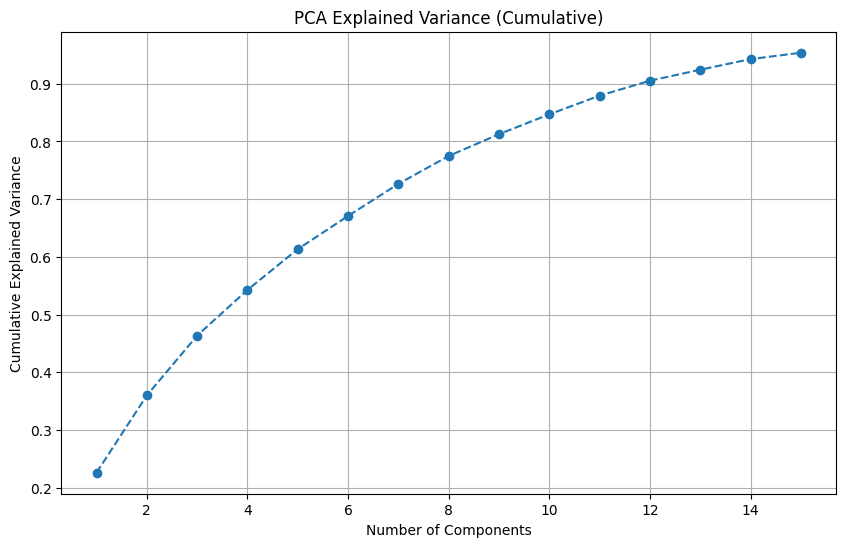

In [25]:
# --- 5. PCA (Principal Component Analysis) ---
# (นี่คือ "การทำอื่นๆ" เพื่อให้ข้อมูลดีที่สุด)

# เราจะใช้ PCA เพื่อลดมิติข้อมูล
# n_components=0.95 หมายถึง ให้คงไว้ซึ่งองค์ประกอบหลักที่อธิบายความแปรปรวนของข้อมูลได้ 95%

pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X_scaled) # X_pca คือ PC1-15 ที่คุณถามถึง

# ดูจำนวน Components ที่ได้
n_components = pca.n_components_
print(f"PCA เสร็จสิ้น: ลดจาก {X_scaled.shape[1]} ฟีเจอร์ เหลือ {n_components} องค์ประกอบหลัก (PC)")
print(f"Total explained variance: {np.sum(pca.explained_variance_ratio_):.4f} (95%)")

# พล็อต Scree Plot เพื่อดู 'Elbow' ของ PCA
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_components + 1), np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.title('PCA Explained Variance (Cumulative)')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

In [26]:
# --- 6. (สำคัญ) ตรวจสอบ PCA Loadings ---
# (Cell นี้จะตอบคำถามคุณว่า PC1, PC2 คืออะไร)

print("--- PCA Loadings (ปัจจัยที่มีอิทธิพลต่อ PC) ---")

# สร้าง DataFrame เพื่อดู "Loadings" (ค่าอิทธิพล)
pca_components_df = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(n_components)], 
    index=FEATURE_COLS
)

# --- แสดงผล PC1 ---
print("\n=== ปัจจัยหลักใน PC1 (แกนที่ 1) ===")
# .sort_values() เพื่อดูว่าฟีเจอร์ไหนดึงค่า PC1 ไปทางบวก (สำคัญมาก) หรือทางลบ (สำคัญมาก)
pc1_loadings = pca_components_df['PC1'].sort_values(ascending=False)
print("--- 5 อันดับแรก (ทางบวก) ---")
display(pc1_loadings.head(5))
print("\n--- 5 อันดับสุดท้าย (ทางลบ) ---")
display(pc1_loadings.tail(5))

# --- แสดงผล PC2 ---
print("\n=== ปัจจัยหลักใน PC2 (แกนที่ 2) ===")
pc2_loadings = pca_components_df['PC2'].sort_values(ascending=False)
print("--- 5 อันดับแรก (ทางบวก) ---")
display(pc2_loadings.head(5))
print("\n--- 5 อันดับสุดท้าย (ทางลบ) ---")
display(pc2_loadings.tail(5))

--- PCA Loadings (ปัจจัยที่มีอิทธิพลต่อ PC) ---

=== ปัจจัยหลักใน PC1 (แกนที่ 1) ===
--- 5 อันดับแรก (ทางบวก) ---


AREA              0.366033
pump_ready        0.326213
population        0.314965
avg_rain_rainy    0.251481
canal_count       0.248288
Name: PC1, dtype: float64


--- 5 อันดับสุดท้าย (ทางลบ) ---


flood_point_density   -0.180463
คะแนนรวม              -0.208039
group_กรุงเทพกลาง     -0.219768
risk_score_per_pump   -0.266468
population_density    -0.322297
Name: PC1, dtype: float64


=== ปัจจัยหลักใน PC2 (แกนที่ 2) ===
--- 5 อันดับแรก (ทางบวก) ---


canal_density        0.382757
floodgate_density    0.373633
group_กรุงธนเหนือ    0.348167
floodgate_count      0.307730
canal_count          0.255592
Name: PC2, dtype: float64


--- 5 อันดับสุดท้าย (ทางลบ) ---


pump_readiness_ratio    -0.139704
group_กรุงเทพกลาง       -0.191166
flood_point_density     -0.279617
flood_point_count       -0.304112
flood_point_per_canal   -0.320287
Name: PC2, dtype: float64


--- 7. กำลังหา K ที่เหมาะสม (Elbow Method) ---


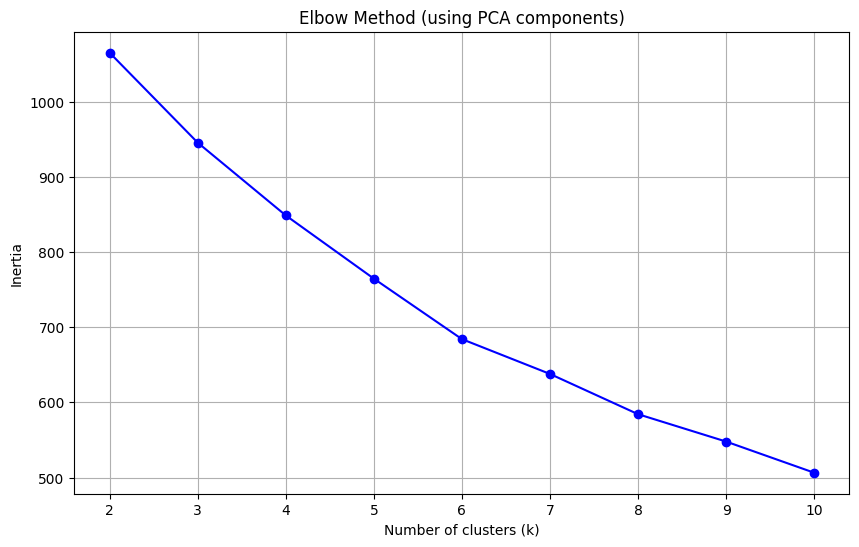

In [27]:
# --- 7. Elbow Method (หา K ที่เหมาะสม) ---
# (เราจะรัน Elbow Method บนข้อมูล X_pca)

print("\n--- 7. กำลังหา K ที่เหมาะสม (Elbow Method) ---")
inertia = []
K_range = range(2, 11) 

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_pca) # <-- ใช้ X_pca
    inertia.append(kmeans.inertia_)

# พล็อต
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertia, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method (using PCA components)')
plt.grid(True)
plt.show()

# (จากกราฟ ให้คุณลองดูว่า K ที่ 3, 4, หรือ 5 เหมาะสมที่สุด)

In [28]:
# --- 8. Final Clustering & Saving Results ---
# (ทับไฟล์เดิมตามที่คุณต้องการ)

print("\n--- 8. รัน K-Means และบันทึกผล ---")

# เลือก K ที่ดีที่สุดจาก Elbow Method (เช่น k=4)
FINAL_K = 4 

kmeans_final = KMeans(n_clusters=FINAL_K, random_state=42, n_init=10)
clusters = kmeans_final.fit_predict(X_pca) # <-- ใช้ X_pca ในการ predict

# === การบันทึกไฟล์ (ทับไฟล์เดิม) ===
# เราจะใช้ 'df' (DataFrame ดั้งเดิม)
# แล้วเพิ่มคอลัมน์ 'cluster' และ 'PC1'...'PC15' เข้าไป

df_clustered = df.copy() # ใช้ df ดั้งเดิม (ที่ population = 99153)
df_clustered['cluster'] = clusters

# (Optional) บันทึก PCA components กลับเข้าไปด้วย
pca_cols = [f'PC{i+1}' for i in range(X_pca.shape[1])]
df_pca_components = pd.DataFrame(X_pca, columns=pca_cols, index=df.index)
df_clustered = pd.concat([df_clustered, df_pca_components], axis=1)

# === นี่คือ Path ที่คุณขอให้ทับ ===
output_filename_clustered = 'master_features_clustered_v2_pca.csv'
output_path_clustered = os.path.join(DATA_DIR, output_filename_clustered) 

df_clustered.to_csv(output_path_clustered)

print(f"!!! บันทึกไฟล์ทับของเดิมเรียบร้อย !!!\nไปที่: {output_path_clustered}")

# แสดงผลการนับ
print("\n--- Cluster Distribution ---")
print(df_clustered['cluster'].value_counts().sort_index())


--- 8. รัน K-Means และบันทึกผล ---
!!! บันทึกไฟล์ทับของเดิมเรียบร้อย !!!
ไปที่: ../data/MODEL_INPUTS/master_features_clustered_v2_pca.csv

--- Cluster Distribution ---
cluster
0    26
1     5
2     8
3    11
Name: count, dtype: int64




--- 9. การวิเคราะห์โปรไฟล์ของกลุ่ม (Cluster Profiling) ---

--- Cluster Profile (Mean Values) ---


cluster,0,1,2,3
AREA,5.136213e+07,8.221211e+06,1.193956e+07,1.011108e+07
population,1.369200e+05,7.321520e+04,1.084984e+05,7.995691e+04
canal_count,3.888462e+01,1.140000e+01,5.900000e+01,1.290909e+01
flood_point_count,5.000000e-01,1.200000e+00,0.000000e+00,9.090909e-02
floodgate_count,1.846154e+00,4.000000e-01,3.000000e+00,2.727273e-01
avg_rain_rainy,2.682051e+00,1.948333e+00,1.910417e+00,1.754545e+00
avg_rain_summer,6.608440e+00,6.122222e+00,6.055556e+00,7.873737e+00
avg_rain_winter,4.330128e+00,4.470833e+00,4.542969e+00,3.644886e+00
pump_ready,1.526923e+01,3.600000e+00,8.000000e+00,6.909091e+00
pump_support,5.538462e+00,2.000000e-01,1.250000e+00,1.818182e+00


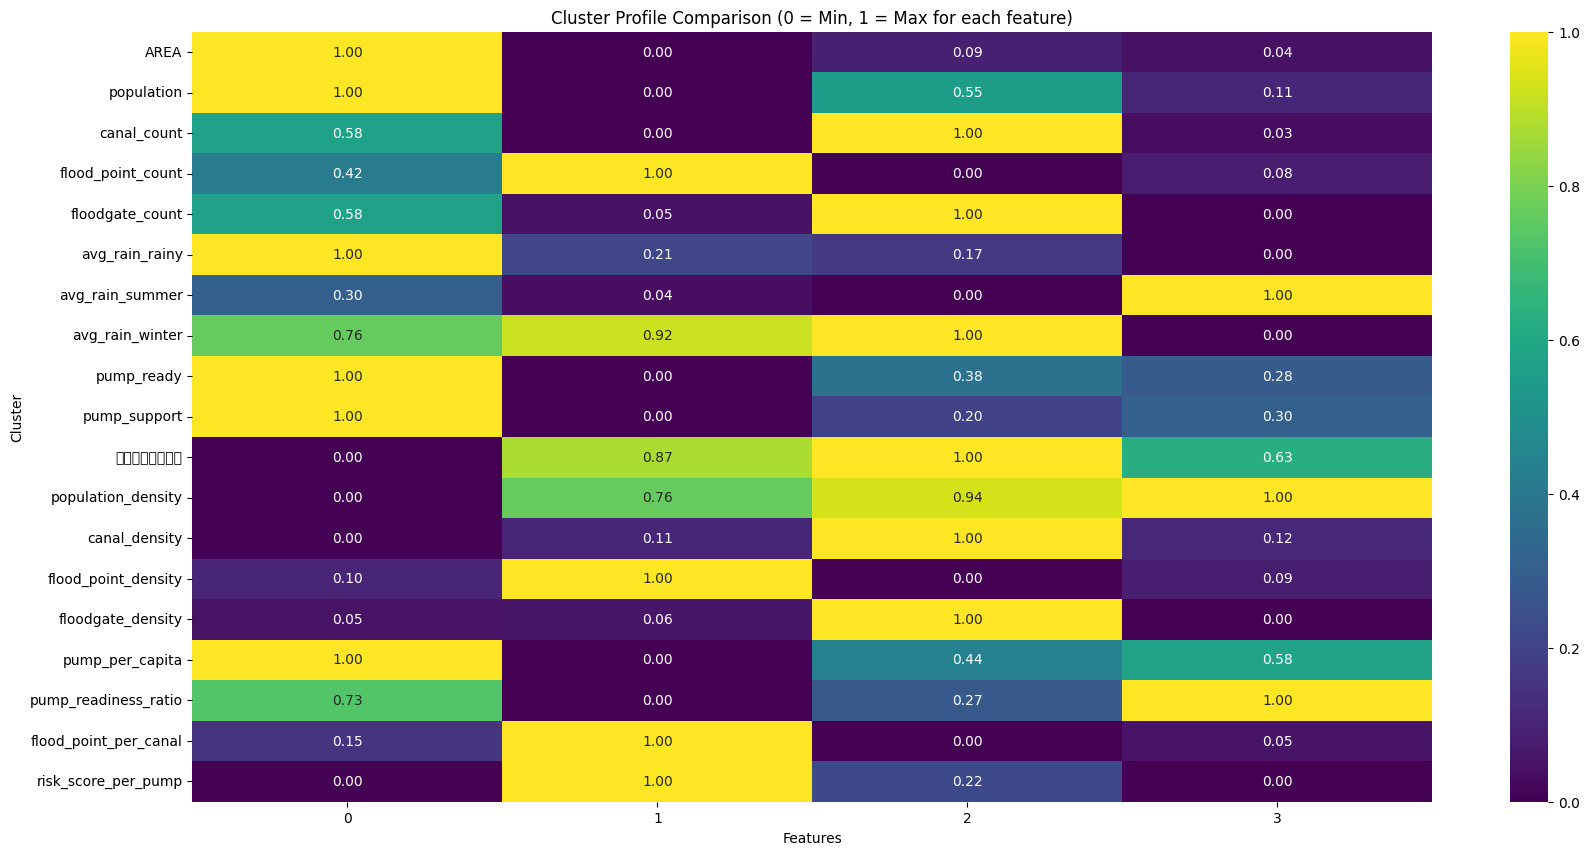

In [29]:
# --- 9. Cluster Profiling (วิเคราะห์ผล) ---
# (นี่คือส่วนที่เราจะใช้ตีความหมายของกลุ่ม โดยไม่สนใจ PC1-15)

print("\n\n" + "="*50)
print("--- 9. การวิเคราะห์โปรไฟล์ของกลุ่ม (Cluster Profiling) ---")
print("="*50)

# 1. กำหนดฟีเจอร์ "ดั้งเดิม" ที่เราต้องการใช้ตีความ
# (เราจะใช้ df_clustered ที่มีค่าดั้งเดิมอยู่แล้ว)
PROFILE_FEATURES = [
    'AREA', 
    'population', 
    'canal_count', 
    'flood_point_count', 
    'floodgate_count',
    'avg_rain_rainy', 
    'avg_rain_summer', 
    'avg_rain_winter',
    'pump_ready', 
    'pump_support',
    'คะแนนรวม', 
    'population_density', 
    'canal_density', 
    'flood_point_density',
    'floodgate_density', 
    'pump_per_capita', 
    'pump_readiness_ratio',
    'flood_point_per_canal', 
    'risk_score_per_pump'
]
PROFILE_FEATURES = [col for col in PROFILE_FEATURES if col in df_clustered.columns]

# 2. Group by 'cluster' และหาค่าเฉลี่ย
cols_to_profile = PROFILE_FEATURES + ['cluster']
cluster_profile = df_clustered[cols_to_profile].groupby('cluster').mean()

print("\n--- Cluster Profile (Mean Values) ---")
display(cluster_profile.T) # .T เพื่อให้ดูง่ายขึ้น

# 3. สร้าง Heatmap เพื่อเปรียบเทียบโปรไฟล์
# (Scale ค่าเฉลี่ยให้อยู่ในช่วง 0-1 เพื่อให้เปรียบเทียบกันได้)

scaler = MinMaxScaler()
# เรา Scale แต่ละฟีเจอร์ (แนวตั้ง, axis=0) เพื่อดูว่ากลุ่มไหน "เด่น" หรือ "ด้อย"
profile_scaled = scaler.fit_transform(cluster_profile)

df_profile_scaled = pd.DataFrame(profile_scaled, 
                                 columns=cluster_profile.columns, 
                                 index=cluster_profile.index)

# วาด Heatmap (เรา .T เพื่อให้ cluster อยู่แกน Y จะดูง่ายกว่า)
plt.figure(figsize=(20, 10))
sns.heatmap(df_profile_scaled.T, annot=True, fmt='.2f', cmap='viridis')
plt.title('Cluster Profile Comparison (0 = Min, 1 = Max for each feature)')
plt.xlabel('Features')
plt.ylabel('Cluster')
plt.show()

# *** การตีความ Heatmap นี้ ***
# - มองหาช่องที่เป็นสีเหลือง (ค่าใกล้ 1.0) 
#   เช่น: ถ้าแถว Cluster 1 เป็นสีเหลืองที่คอลัมน์ 'avg_rain_rainy' 
#   แปลว่า "Cluster 1 คือกลุ่มที่ฝนตกหนักที่สุดในฤดูฝน"
# - มองหาช่องที่เป็นสีม่วง (ค่าใกล้ 0.0)
#   เช่น: ถ้าแถว Cluster 1 เป็นสีม่วงที่คอลัมน์ 'pump_ready'
#   แปลว่า "Cluster 1 คือกลุ่มที่มีเครื่องสูบน้ำพร้อมใช้น้อยที่สุด"

In [30]:
# --- 10. แสดงรายชื่อเขตในแต่ละกลุ่ม ---

print("\n--- รายชื่อเขตในแต่ละกลุ่ม ---")
FINAL_K = 4 # จำนวนกลุ่มที่เราตั้งไว้
for i in range(FINAL_K):
    print(f"\n=== Cluster {i} ({df_clustered[df_clustered['cluster'] == i].shape[0]} เขต) ===")
    
    # ดึงรายชื่อเขต
    districts_in_cluster = df_clustered[df_clustered['cluster'] == i]['dname'].tolist()
    print(", ".join(districts_in_cluster))
    
    # (Optional) ดูว่าอยู่ในกลุ่มพื้นที่ไหนบ้าง
    print(f"-- (กลุ่มพื้นที่: {df_clustered[df_clustered['cluster'] == i]['district_group'].unique()})")

print("\n--- จบการทำงาน Notebook 04 ---")


--- รายชื่อเขตในแต่ละกลุ่ม ---

=== Cluster 0 (26 เขต) ===
เขตวังทองหลาง, เขตทวีวัฒนา, เขตลาดกระบัง, เขตตลิ่งชัน, เขตสะพานสูง, เขตบางแค, เขตสวนหลวง, เขตประเวศ, เขตหนองแขม, เขตราษฏร์บูรณะ, เขตบางบอน, เขตบางขุนเทียน, เขตดอนเมือง, เขตหนองจอก, เขตสายไหม, เขตคลองสามวา, เขตหลักสี่, เขตบางเขน, เขตจตุจักร, เขตคันนายาว, เขตมีนบุรี, เขตลาดพร้าว, เขตบางซื่อ, เขตบึงกุ่ม, เขตบางกะปิ, เขตทุ่งครุ
-- (กลุ่มพื้นที่: ['กรุงเทพกลาง' 'กรุงธนเหนือ' 'กรุงเทพตะวันออก' 'กรุงธนใต้' 'กรุงเทพใต้'
 'กรุงเทพเหนือ'])

=== Cluster 1 (5 เขต) ===
เขตดุสิต, เขตพญาไท, เขตราชเทวี, เขตพระนคร, เขตปทุมวัน
-- (กลุ่มพื้นที่: ['กรุงเทพกลาง' 'กรุงเทพใต้'])

=== Cluster 2 (8 เขต) ===
เขตบางพลัด, เขตบางกอกน้อย, เขตบางกอกใหญ่, เขตภาษีเจริญ, เขตธนบุรี, เขตคลองสาน, เขตจอมทอง, เขตบางคอแหลม
-- (กลุ่มพื้นที่: ['กรุงธนเหนือ' 'กรุงธนใต้' 'กรุงเทพใต้'])

=== Cluster 3 (11 เขต) ===
เขตห้วยขวาง, เขตดินแดง, เขตป้อมปราบศัตรูพ่าย, เขตวัฒนา, เขตสัมพันธวงศ์, เขตคลองเตย, เขตบางรัก, เขตสาทร, เขตยานนาวา, เขตพระโขนง, เขตบางนา
-- (กลุ่มพื้นที่: ['กร